In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from icedef import constants, iceberg, metocean, drift, tools, simulator
from icedef import statoil_arcticnet_data as statoil_data

# Setup Initial Conditions and Reference Track

In [2]:
df = statoil_data.get_df(statoil_data.dir_path, statoil_data.csv_filenames[2])

start_index = 1100
end_index = 1120

ref_berg = statoil_data.create_ref_berg_from_df(df, start_index, end_index)
ref_lats = xr.DataArray(ref_berg.history['latitude'], coords=[ref_berg.history['time']], dims=['time'])
ref_lons = xr.DataArray(ref_berg.history['longitude'], coords=[ref_berg.history['time']], dims=['time'])

start_time = np.datetime64(df.DataDate_UTC[start_index])
end_time = np.datetime64(df.DataDate_UTC[end_index])

start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
#start_velocity = statoil_data.get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)
start_velocity = (0.06412841, -0.10386169)  # hard-coding initial berg velocity to equal initial current velocity

time_step = np.timedelta64(360, 's')
time_info = (time_step, end_time)

# Run Test Simulation

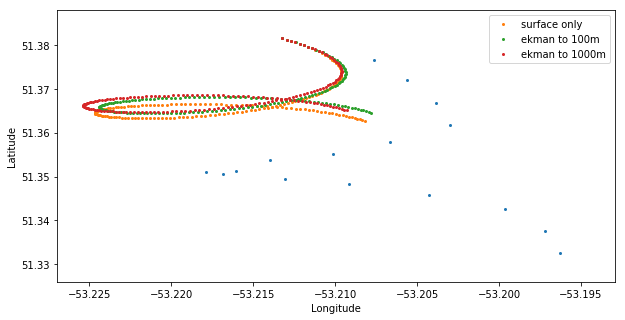

In [5]:
xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True)

fig = plt.figure(figsize=(10, 5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(ref_lons, ref_lats, s=4)

xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=False)

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='surface only')


xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True)

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='ekman to 100m')


xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                                start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True,
                                depth_vec=np.arange(0, -1100, -100))

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='ekman to 1000m')


plt.legend()
plt.show()

# Optimize Ca and Cw

In [4]:
optimization_result = sim.run_optimization((ref_lats[:10], ref_lons[:10]), 
                                           (start_latitude, start_longitude), 
                                           (start_time, end_time))

optimization_result

      fun: 0.006444041236382686
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.36019537e-05, -3.30803093e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 13
   status: 0
  success: True
        x: array([2.63949573, 8.50715112])

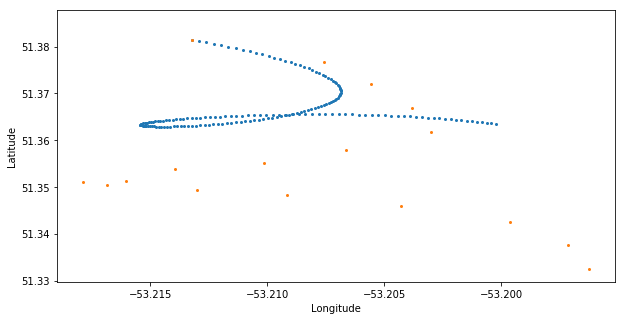

In [5]:
sim = simulator.Simulator()

Ca, Cw = optimization_result.x

xds = sim.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                          start_velocity=start_velocity, Ca=Ca, Cw=Cw)

fig = plt.figure(figsize=(10, 5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(xds['longitude'], xds['latitude'], s=4)
plt.scatter(ref_lons, ref_lats, s=4)
plt.show()